In this notebook, we provide a brief discussion of learning dynamics – of how players might learn to play a Nash equilibrium over time, while repeatedly playing a game. We will look at two simple learning dynamics: _Best response dynamics_ and _fictitious play_. We will also look at _damped_ versions of these dynamics.

We import numpy for computations and matplotlib for beautiful plots.

我们在这一节中讨论博弈论的学习过程，理解动态均衡的产生，特别是介绍Best response的概念和自我对局算法

In [1]:
import numpy
import matplotlib.pyplot as plt

The following code generates plots from appropriately specified numpy.array 'data':      

In [2]:
def make_plot(data):
    f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8),dpi=220, facecolor='w', edgecolor='k')
    ax1.plot(data[:,0],label="first player")
    ax1.plot(data[:,1],label="second player")
    ax1.set_xlabel("iterations")
    ax1.set_ylabel("strategy")
    ax1.legend(loc="upper right", bbox_to_anchor=(1,-0.05))  
    
    ax2.plot(data[:,0],data[:,1],'.--',label="strategy profile")
    ax2.annotate("", xy=(data[1,0], data[1,1]), xytext=(data[0,0], data[0,1]),arrowprops=dict(arrowstyle="fancy"))
    ax2.set_xlabel("first player's strategy")
    ax2.set_ylabel("second player's strategy")
    ax2.legend()
    plt.show()        

----

## Best response dynamics

The simplest learning dynamics one might consider is where each player plays a best response to what
was played by other players the last time they played the game. For example, in a Cournot competition
setting where two firms compete with each other every day, each firm might decide to play the best
response to the quantity the other firm produced the previous day. This process is called the best
response dynamics.

Formally, we can write this as follows. Let $\sigma_i^t$ denote the
(mixed) strategy played by player $i$ at time $t$.
\begin{enumerate}
\item At time $t=0$, each player $i$ plays an arbitrary strategy
  $\sigma_i^0$.
\item At any time $t \geq 1$, each player $i$ plays a best response
  $\sigma_i^t$ to the strategy profile of other players
  $\sigma_{-i}^{t-1}$ at time $t-1$. In other words, we assume
  $\sigma_i^t \in BR_i(\sigma_{-i}^{t-1})$ for each $i$.
\end{enumerate}

For the best response dynamics, we can show that if for each $i$ the
strategies $\sigma_i^t$ converge to $\sigma_i^*$ as $t$ increases to
infinity, then the limiting strategy profile
$\sigma^* = (\sigma_1^*, \cdots, \sigma_N^*)$ is a (mixed) Nash
equilibrium. Thus, when we have convergence, the best response
dynamics provides a simple method to compute a Nash equilibrium.


### Example: Cournot competition

Consider an oligopoly with two firms $i \in \{1,2\}$, who each produce
a single homogeneous commodity. Each firm $i$ must decide her
production level $q_i \geq 0$. The cost of production for firm $i$ is
given by $c_i(q_i)$. Once the production levels are determined (and
produced), the total quantity of the commodity $Q = q_1 + q_2$ will be
sold in the market at the "market clearing" price $P(Q)$, where the
market is said to clear when the total supply of goods is equal to the
total demand at that price. (Hence $P(\cdot)$ is also called the
\emph{inverse demand function}.) Each firm seeks to maximize her
profit, which is her revenue minus her cost of production:
\begin{align*}
\pi_i(q_i, q_{-i}) &= q_i P(Q) - c_i(q_i)\\
&= q_i P(q_i + q_{-i}) - c_i(q_i).
\end{align*}

The best response set for firm $i$ is defined as 
\begin{align*}
    BR_i(q_{-i}) = \left\lbrace q_i : \pi_i(q_i , q_{-i}) \geq \pi_i(q_i',q_{-i}) \text{ for all $q_i'$} \right\rbrace
\end{align*}

The following code computes the best response set when $P(Q) = (a - bQ)^+$ and $c_i(q_i) = c_i q_i$, where the best response set is given by $BR_i(q_{-i}) = \left\{ \frac{(a - bq_{-i} - c_i)^+}{2b}\right\}$.

In [3]:
# Pricing function is P(Q) = (a - bQ)^+
a = 9
b = 1

# Production cost c_i(q_i) = c_iq_i. The value of c_i is below.
c=[1,0.5]

# number of iterations
num_iter=15

# Best response function
# BR_i(q_{-i}) = \{ \frac{(a - c_i - bq_{-i})^+}{2b} \}
def best_response(a,b,c,q):
    return max((a-c-b*q)/(2*b),0)

The best response dynamics is then given by
\begin{enumerate}
\item On day $0$, firm $i$ produces an arbitrary quantity $q_i^0$.
\item On days $t \geq 1$, firm $i$ produces a quantity $q_i^{t}$ that is a best response to other firms' quantity in day $t-1$, $q_{-i}^{t-1}$:
\begin{align*}
q_i^t \in BR_i(q_{-i}^{t-1}).
\end{align*}
\end{enumerate}

The following code implements the best response dynamics for $P(Q) = (a - bQ)^+$ and $c_i(q_i) = c_i q_i$:

In [5]:
# Each firms' quantity
quantity = numpy.zeros([num_iter,3])

#initial quantities
quantity[0,0] = 3.6
quantity[0,1] = 7.6

for i in range(1, num_iter):
    quantity[i,0] = best_response(a,b,c[0],quantity[i-1,1])
    quantity[i,1] = best_response(a,b,c[1],quantity[i-1,0])
    quantity[i,2] = i/num_iter 

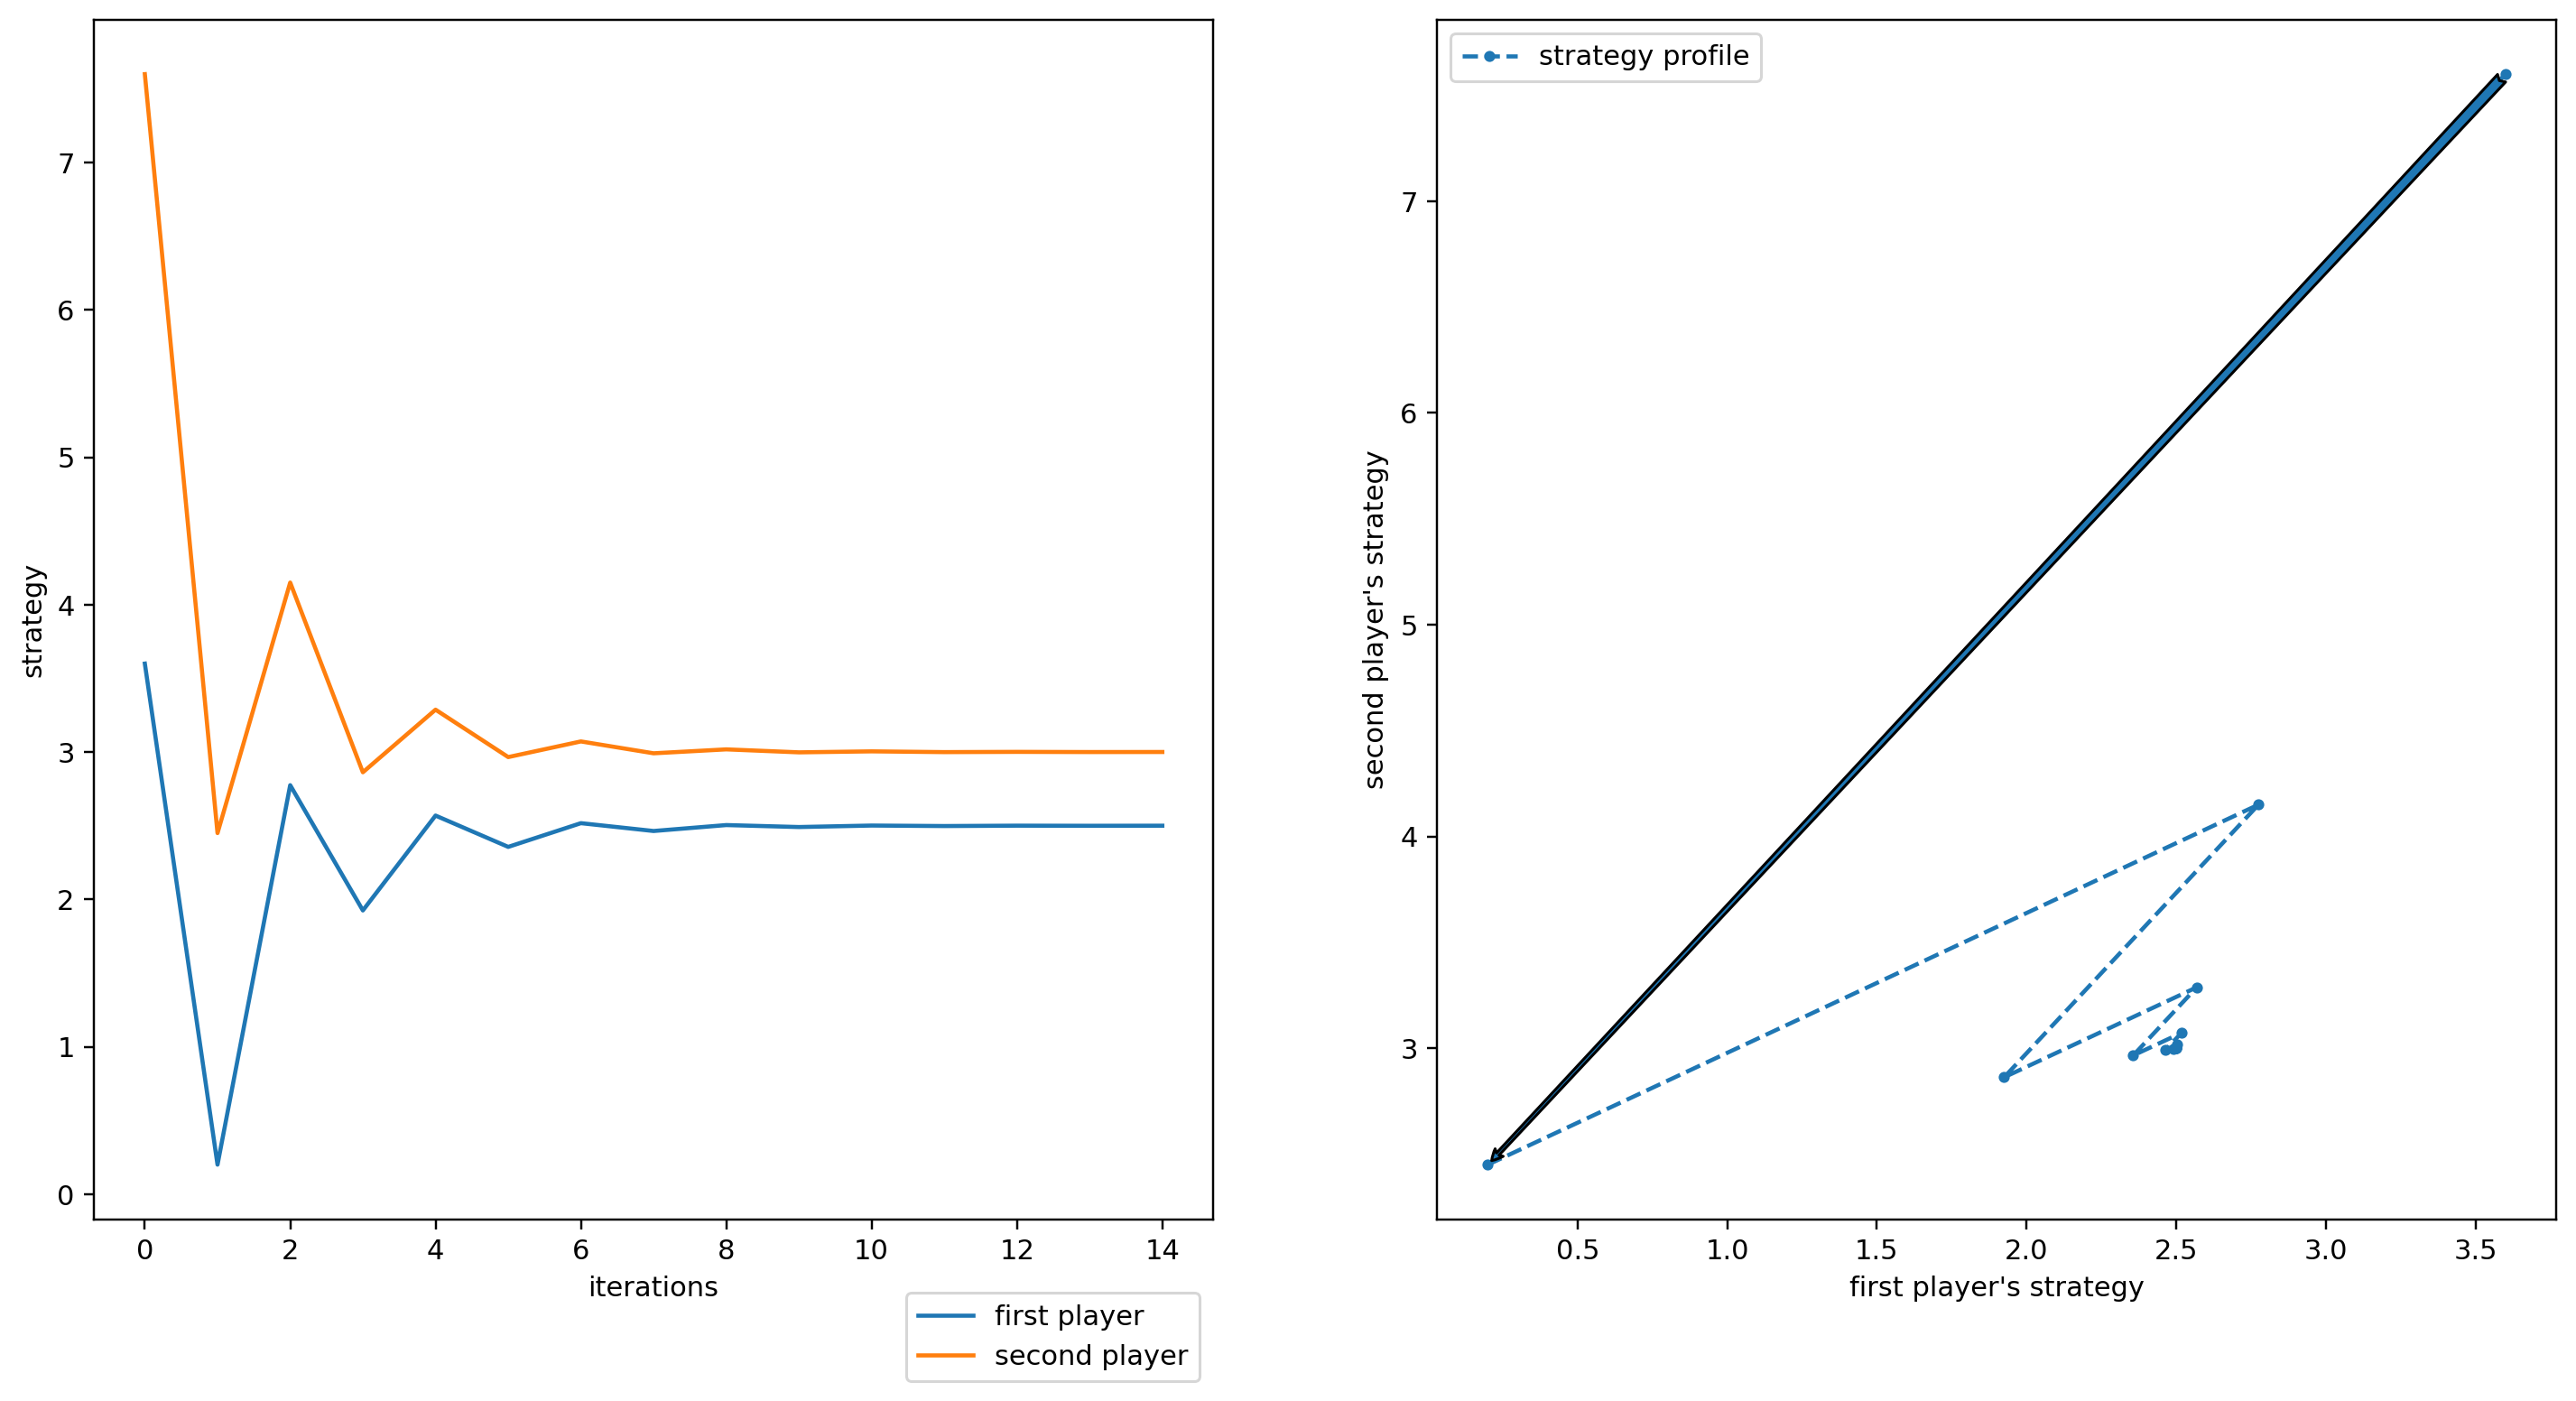

In [6]:
make_plot(quantity)

We see from the plots above that the best response dynamics not only converges, but converges fairly quickly. The limiting quantities then constitute the Nash equilibrium of the Cournot competition. 

In [6]:
print("Player 1's strategy: "+ str(round(quantity[num_iter-1,0],3)))
print("Player 2's strategy: "+ str(round(quantity[num_iter-1,1],3)))

Player 1's strategy: 2.5
Player 2's strategy: 3.0


It is instructive to run the best response dynamics from different initial strategies; you will see that the dynamics always converge to the same point, the unique Nash equilibrium for the Cournot competition.

## Damped best response

Since the best response dynamics can often lead to wild jumps in the
strategies being played, one can consider a "damped" version, where
each player only takes a (small) step towards the best response at
each time, instead of completely moving to the best
response. Formally, we have the following:
\begin{enumerate}
\item At time $t=0$, each player $i$ plays an arbitrary strategy
  $\sigma_i^0$.
\item At any time $t \geq 1$, let
  $\tilde{\sigma}_i^t \in BR_i(\sigma_{-i}^{t-1})$ for each $i$. Each
  player $i$ plays the strategy $\sigma_i^t$, where
  \begin{align*}
  \sigma_i^t = (1-\alpha) \sigma_i^{t-1} + \alpha \tilde{\sigma}_i^t,
  \end{align*}
  for some $\alpha \in (0,1)$.   
\end{enumerate}

Here $\alpha$ denotes the step size -- also known as the \textit{damping factor} -- and captures how aggressive the player is in playing the best response. For $\alpha = 1$, we get the original best response dynamics. On the other hand, for $\alpha = 0$, each player just keeps playing the same strategy profile $\sigma_i^0$ each time period.

The damped best response dynamics has similar properties to the best
response dynamics -- if it converges, the limit is a Nash
equilibrium. The trajectories of the damped best response dynamics are
smoother than that of the best response dynamics, but convergence typically takes longer.

### Example: Cournot Competition

We continue with the example of a Cournot competition, and see how damping affects the dynamics.

In [7]:
# Pricing function is P(Q) = (a - bQ)^+
a = 9
b = 1

# Production cost c_i(q_i) = c_iq_i. The value of c_i is below.
c=[1,0.5]

# Number of iterations
num_iter = 100

# Best response function
# BR_i(q_{-i}) = \{ \frac{(a - c_i - bq_{-i})^+}{2b} \}
def best_response(a,b,c,q):
    return max((a-c-b*q)/(2*b),0)

Recall that higher the damping factor, closer the dynamics is to the best-response dynamics. We will consider fairly conservative values of $\alpha$ that are close to zero. The following code implements the damped best reponse dynamics.

In [8]:
# Damping factor
alpha = 0.1

# Each firms' quantity
quantity = numpy.zeros([num_iter,3])
quantity[0,0] = 3.6
quantity[0,1] = 7.6

for i in range(1, num_iter):
    quantity[i,0] = (1-alpha)*quantity[i-1,0] + alpha*best_response(a,b,c[0],quantity[i-1,1])
    quantity[i,1] = (1-alpha)*quantity[i-1,1] + alpha*best_response(a,b,c[1],quantity[i-1,0])
    quantity[i,2] = i/num_iter 

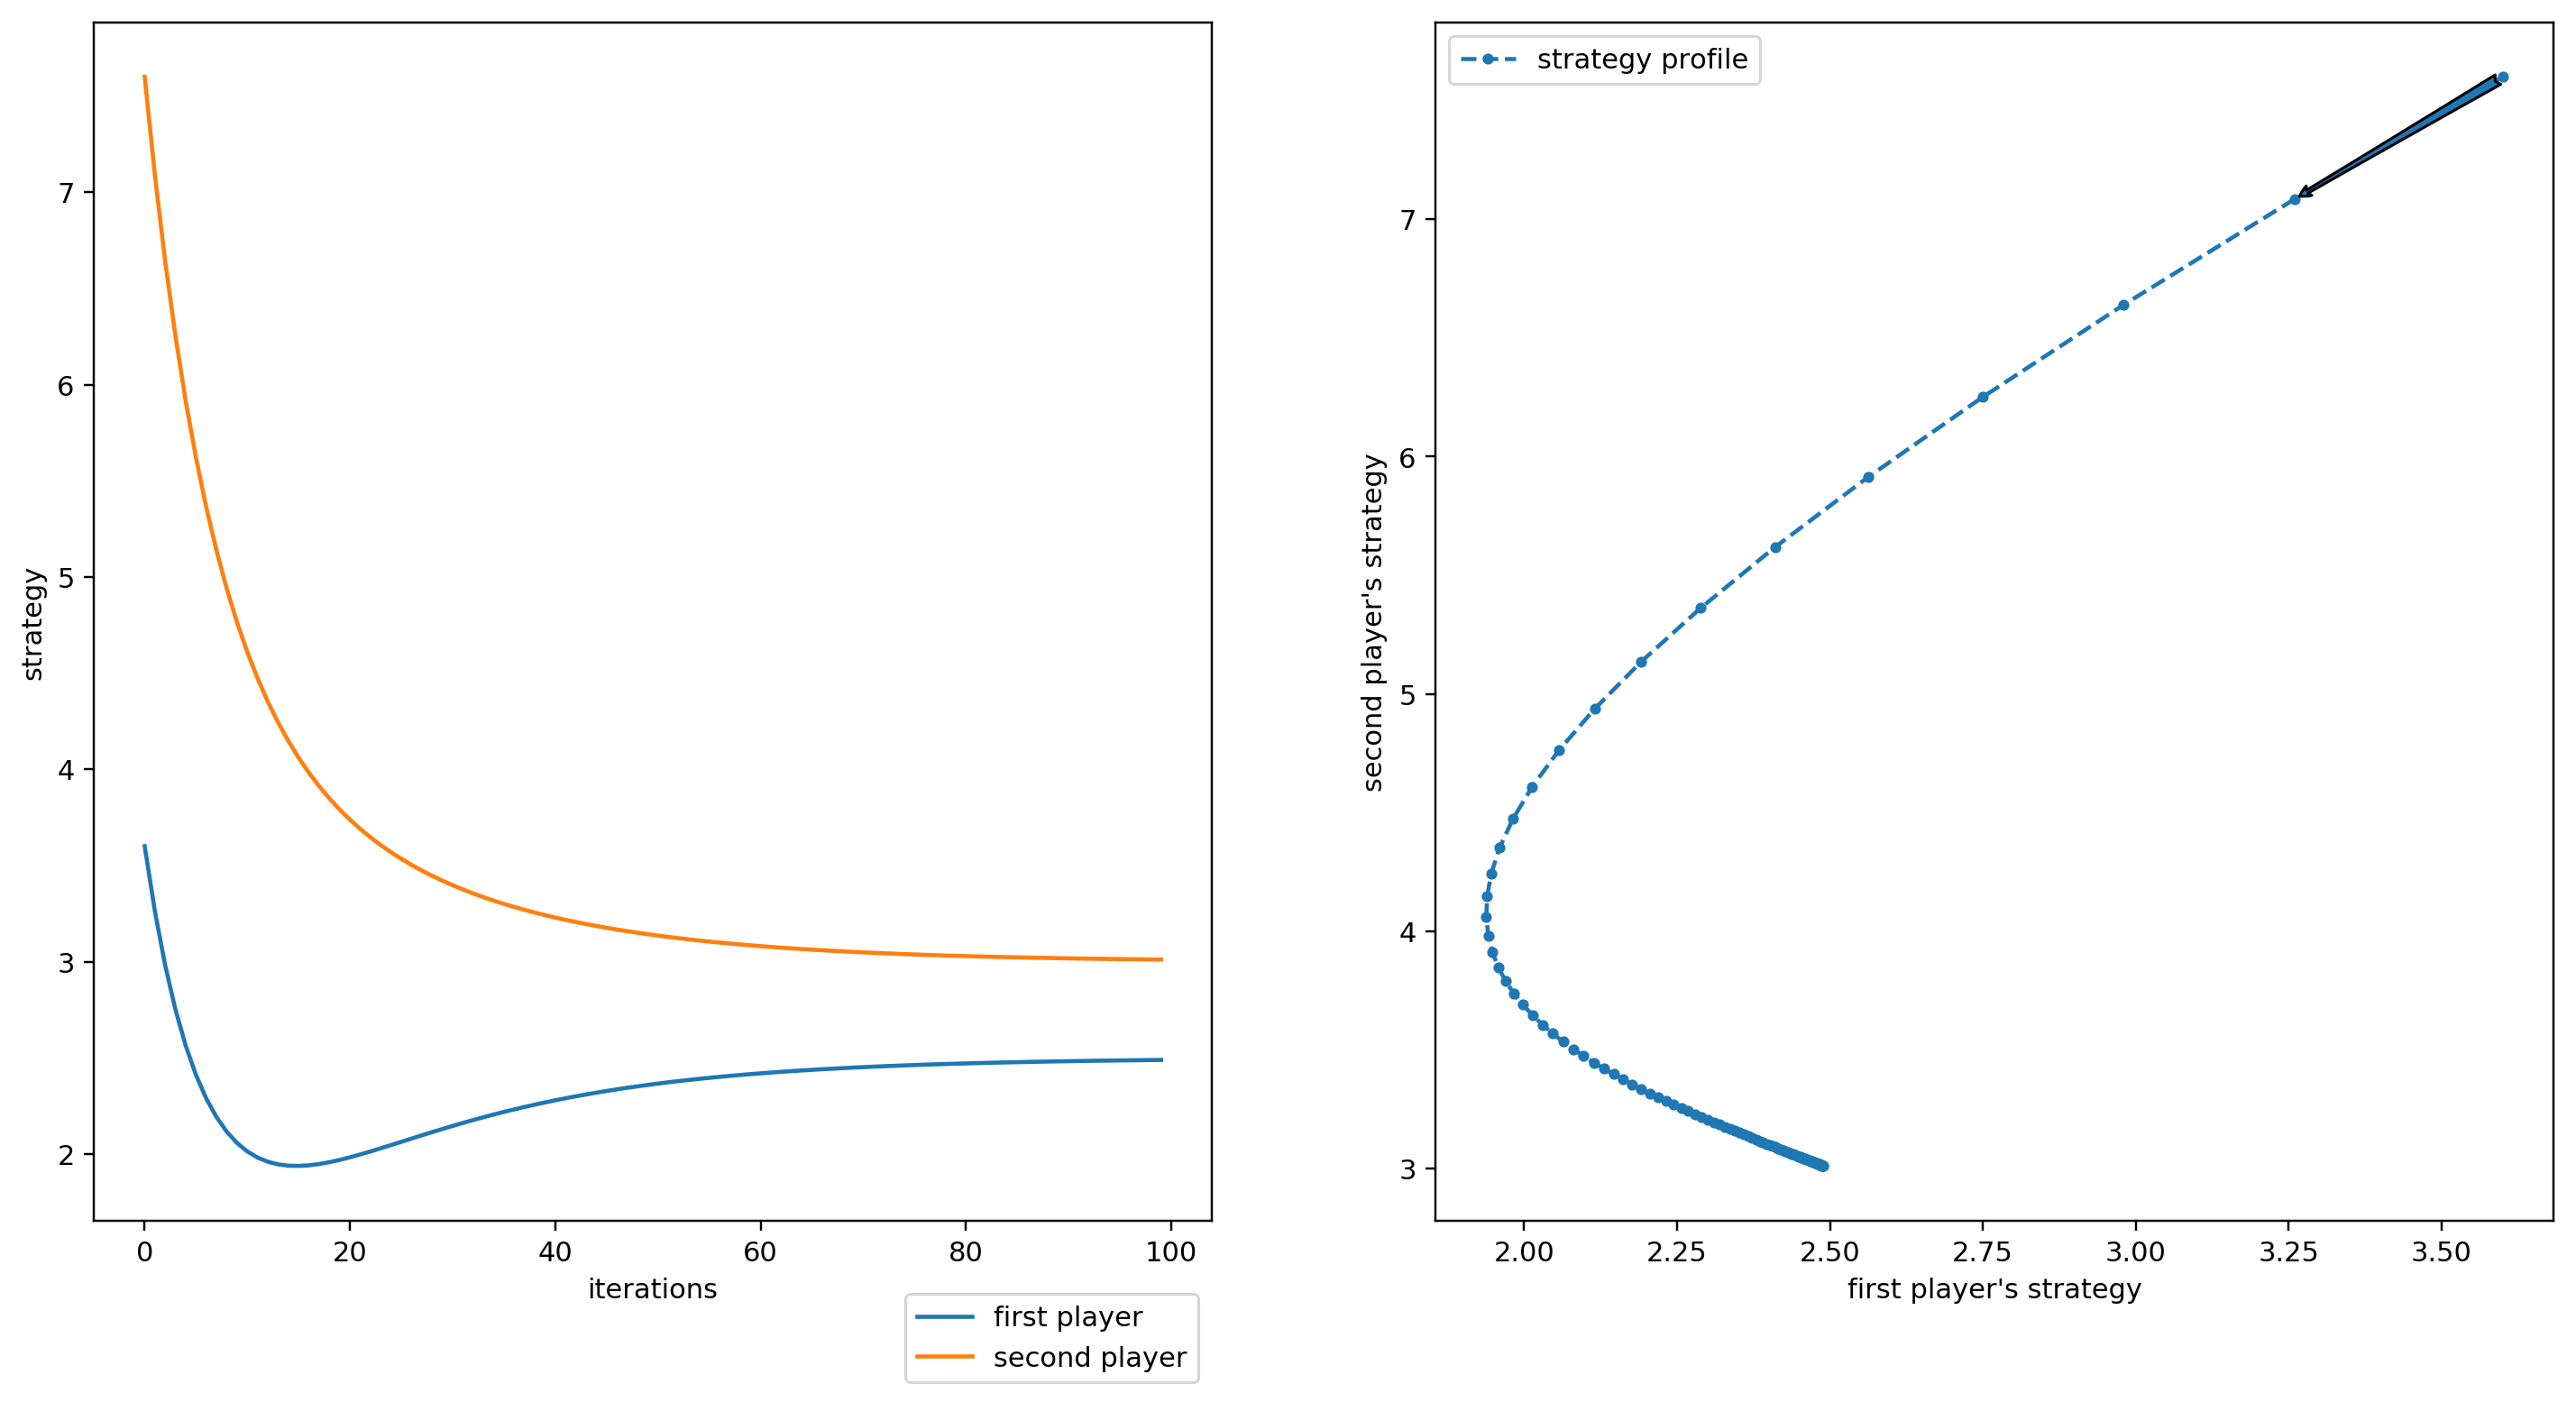

In [9]:
make_plot(quantity)

We see from the plots that the dynamics converges, and the trajectory is much smoother. Furthermore, the convergence is to the Nash equilibrium identified earlier, as seen below.

In [10]:
print("Player 1's strategy: "+ str(round(quantity[num_iter-1,0],3)))
print("Player 2's strategy: "+ str(round(quantity[num_iter-1,1],3)))

Player 1's strategy: 2.489
Player 2's strategy: 3.011


However, we see that now lot more iterations are needed for convergence.

---

## General 2x2 games

We test out the two versions of the best response dynamics for a general two-player two-actions game. The following code defines the payoff matrices for the two players. (Commented out code defines some other payoff matrices worth analyzing.)

In [11]:
# payoff matrix for the two players in the 2x2 game
# first two rows are player 1's payoff matrix, and the last two player 2's

payoff_matrix = numpy.zeros([4,2])


payoff_matrix[:2,:] = [[1, -2],[-3, 1]]
payoff_matrix[2:,:] = [[-3, 1],[5, -1]]



# matching pennies
#payoff_matrix[:2,:] = [[1, -1],[-1, 1]]
#payoff_matrix[2:,:] = [[-1, 1],[1, -1]]


# coordination game
#payoff_matrix[:2,:] = [ [1, 0], [0, 2]]
#payoff_matrix[2:,:] = [ [2, 0], [0, 1]]


# prisoner's dilemma
#payoff_matrix[:2,:] = [ [-1, -10], [0, -5]]
#payoff_matrix[2:,:] = [ [-1, 0], [-10, -5]]

# random game (with positive payoffs in [0,1])
#payoff_matrix = numpy.random.rand(4,2)

# random zero sum game (with positive payoffs for player 1 in [0,1])
#payoff_matrix = numpy.random.rand(4,2)
#payoff_matrix[2:,:]=-payoff_matrix[:2,:]

For these payoff matrices, we compute the best response dynamics, using the following code.

In [12]:
# number of iterations
num_iter = 20

# 'strategy' stores each players' mixed strategy (probability of action 1 in each case)
strategy = numpy.zeros([num_iter,3])


payoffs = numpy.zeros([2,2])


for i in range(1,num_iter):

    # calculate payoff of player 1 assuming player 2 plays the strategy played in the previous round
    payoffs[0,0] = (1- strategy[i-1,1])*payoff_matrix[0,0] + strategy[i-1,1]*payoff_matrix[0,1]
    payoffs[1,0] = (1- strategy[i-1,1])*payoff_matrix[1,0] + strategy[i-1,1]*payoff_matrix[1,1]

    # calculate payoff of player 2 assuming player 1 plays the strategy played in the previous round
    payoffs[0,1] = (1-strategy[i-1,0])*payoff_matrix[2,0] + strategy[i-1,0]*payoff_matrix[3,0]
    payoffs[1,1] = (1-strategy[i-1,0])*payoff_matrix[2,1] + strategy[i-1,0]*payoff_matrix[3,1]


    # player 1's best response
    if payoffs[0,0] < payoffs[1,0]:
        strategy[i,0] = 1
    elif payoffs[0,0] > payoffs[1,0]:
        strategy[i,0] = 0
    else:
        strategy[i,0] = strategy[i-1,0]


    # player 2's best response
    if  payoffs[0,1] < payoffs[1,1]:
        strategy[i,1] = 1
    elif payoffs[0,1] > payoffs[1,1]:
        strategy[i,1] = 0
    else:
        strategy[i,1] = strategy[i-1,1]


    # store the (normalized) number of iterations
    strategy[i,2] = i/num_iter

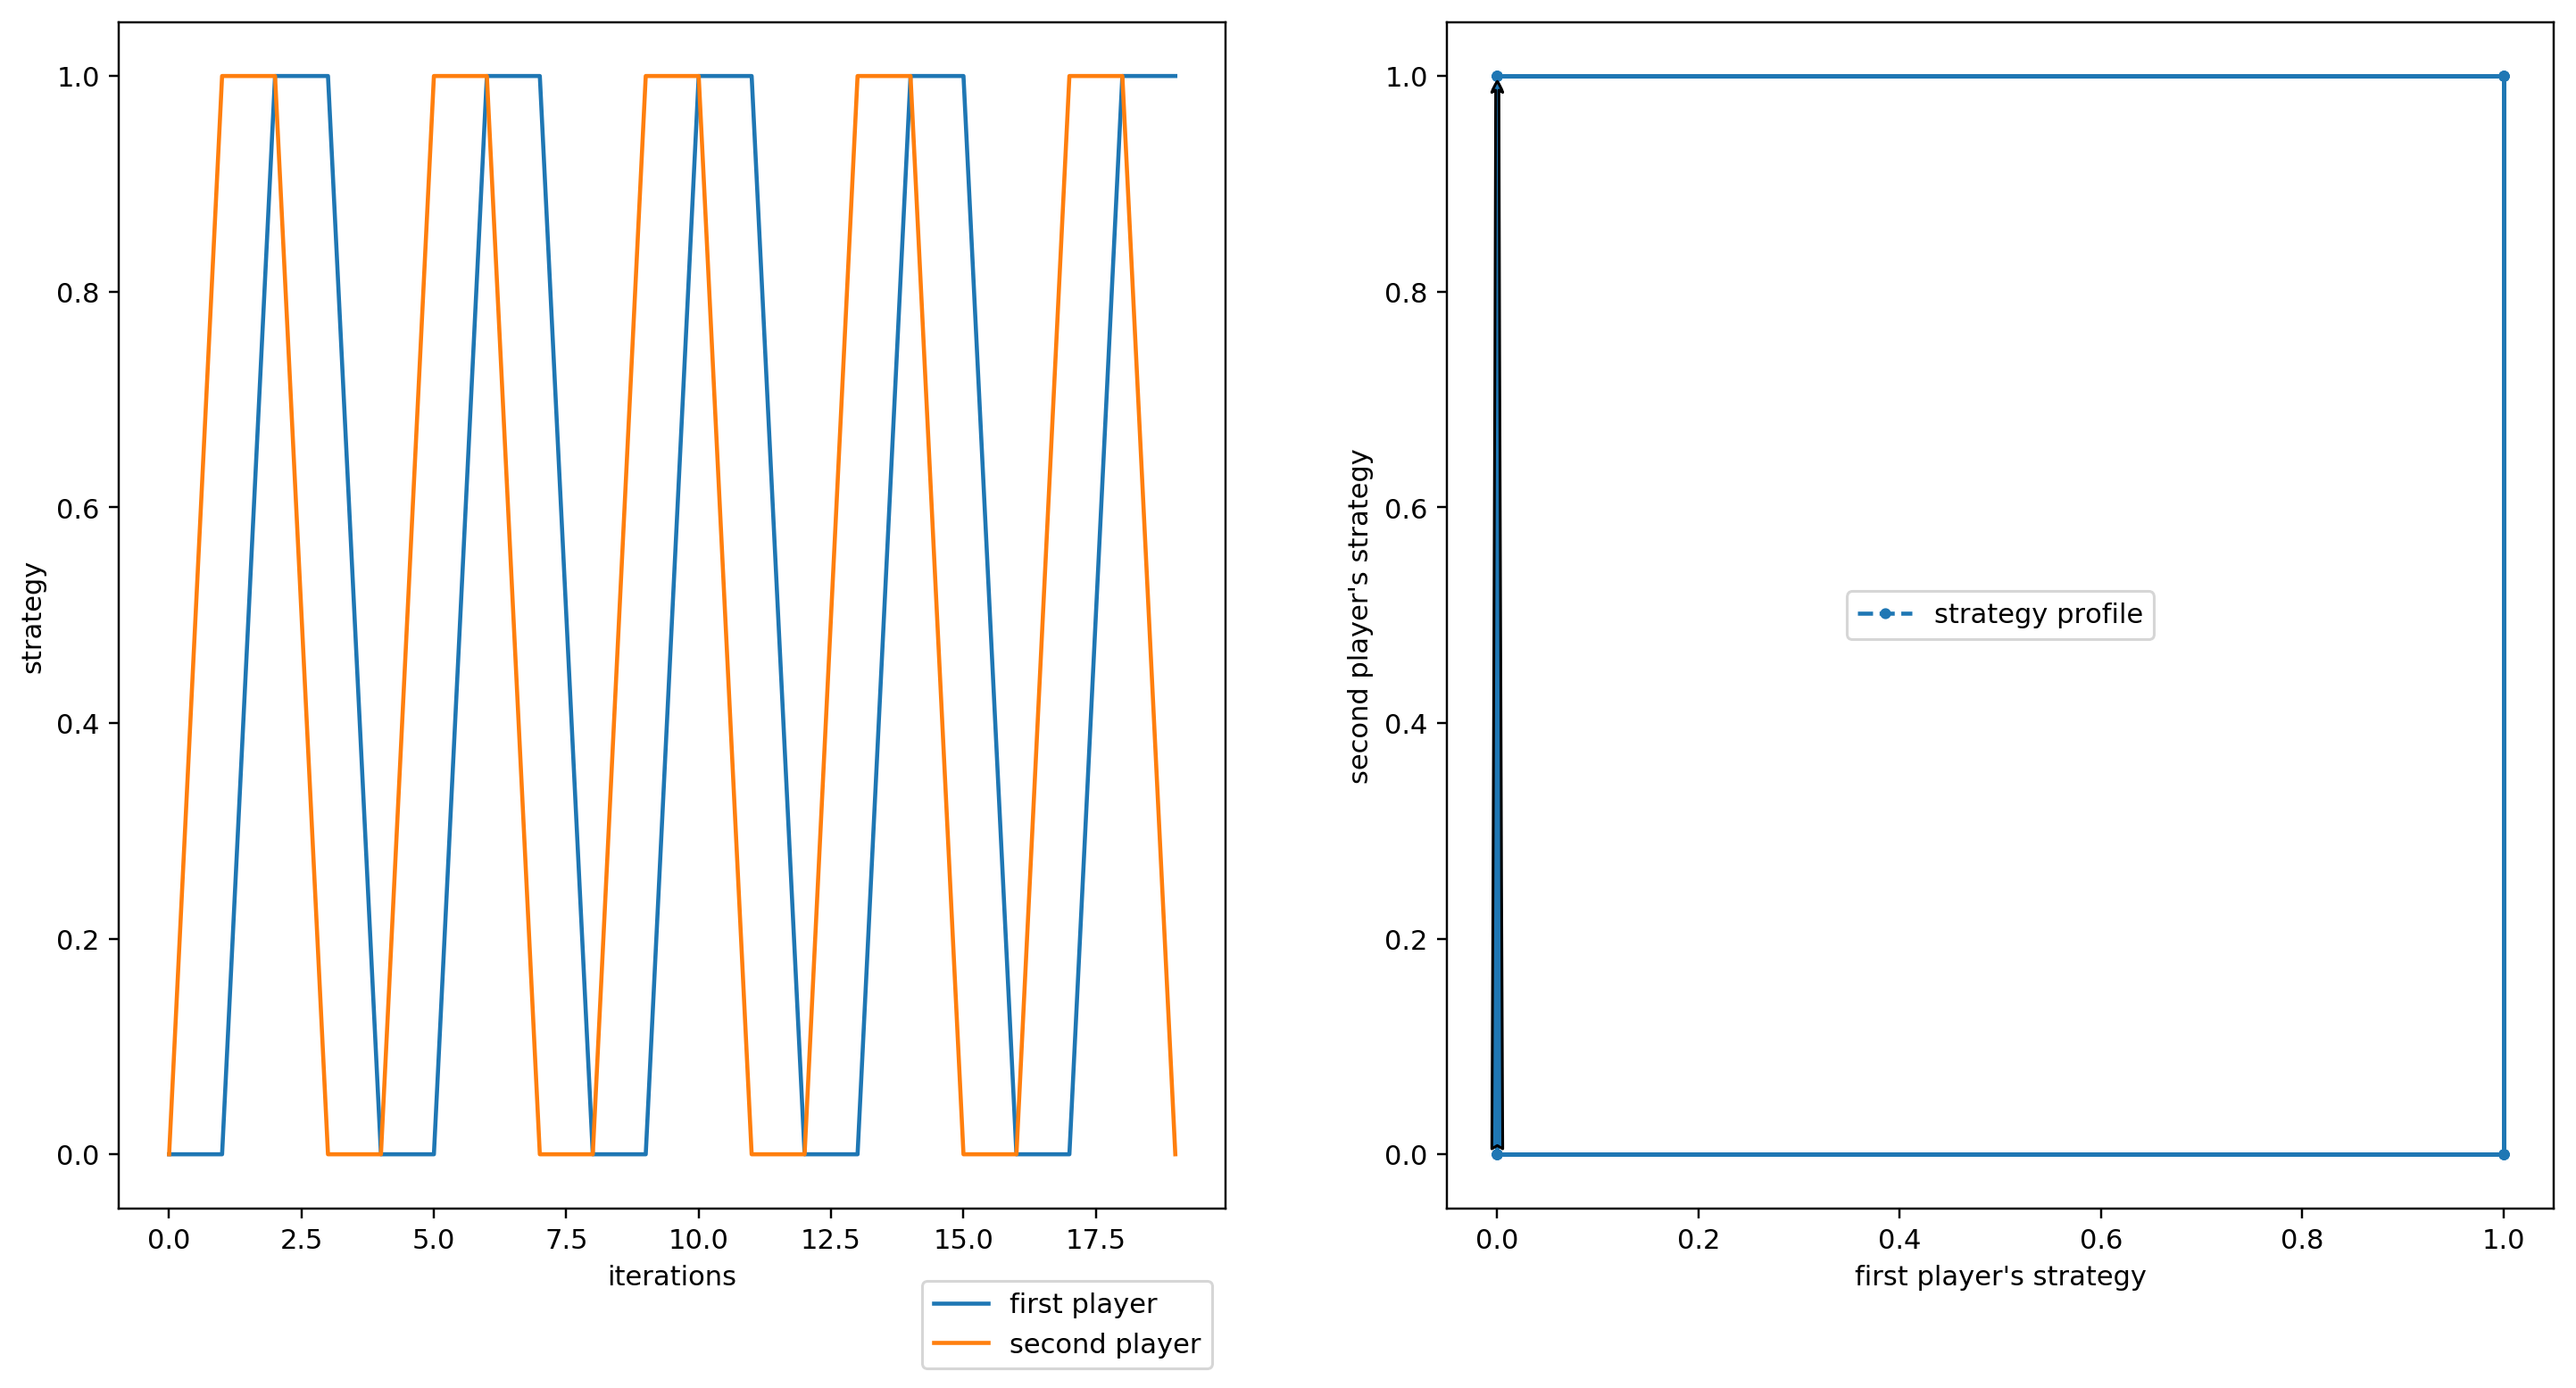

In [13]:
make_plot(strategy)

From the plot, we see that the best response dynamics does not converge, but keeps cycling between the four strategy profiles. Thus, we have an example of a game where the best-response dynamics fails to find the mixed Nash equilibrium.

Moreover, as the following plots show, the damped version of the best response dynamics also fails to converge, even after 1000 iterations. 

In [14]:
# damping factor
alpha = 0.1

# number of iterations
num_iter = 1000

# 'strategy' stores each players' mixed strategy (probability of action 1 in each case)
strategy = numpy.zeros([num_iter,3])

payoffs = numpy.zeros([2,2])

for i in range(1,num_iter):

    # calculate payoff of player 1 assuming player 2 plays the strategy played in the previous round
    payoffs[0,0] = (1- strategy[i-1,1])*payoff_matrix[0,0] + strategy[i-1,1]*payoff_matrix[0,1]
    payoffs[1,0] = (1- strategy[i-1,1])*payoff_matrix[1,0] + strategy[i-1,1]*payoff_matrix[1,1]

    # calculate payoff of player 2 assuming player 1 plays the strategy played in the previous round
    payoffs[0,1] = (1-strategy[i-1,0])*payoff_matrix[2,0] + strategy[i-1,0]*payoff_matrix[3,0]
    payoffs[1,1] = (1-strategy[i-1,0])*payoff_matrix[2,1] + strategy[i-1,0]*payoff_matrix[3,1]


    # player 1's best response with damping
    if payoffs[0,0] < payoffs[1,0]:
        strategy[i,0] = (1-alpha)*strategy[i-1,0] + alpha*1
    elif payoffs[0,0] > payoffs[1,0]:
        strategy[i,0] = (1-alpha)*strategy[i-1,0] + alpha*0
    else:
        strategy[i,0] = strategy[i-1,0]


    # player 2's best response with damping
    if  payoffs[0,1] < payoffs[1,1]:
        strategy[i,1] = (1-alpha)*strategy[i-1,1] + alpha*1
    elif payoffs[0,1] > payoffs[1,1]:
        strategy[i,1] = (1-alpha)*strategy[i-1,1] + alpha*0
    else:
        strategy[i,1] = strategy[i-1,1]


    # store the (normalized) number of iterations
    strategy[i,2] = i/num_iter

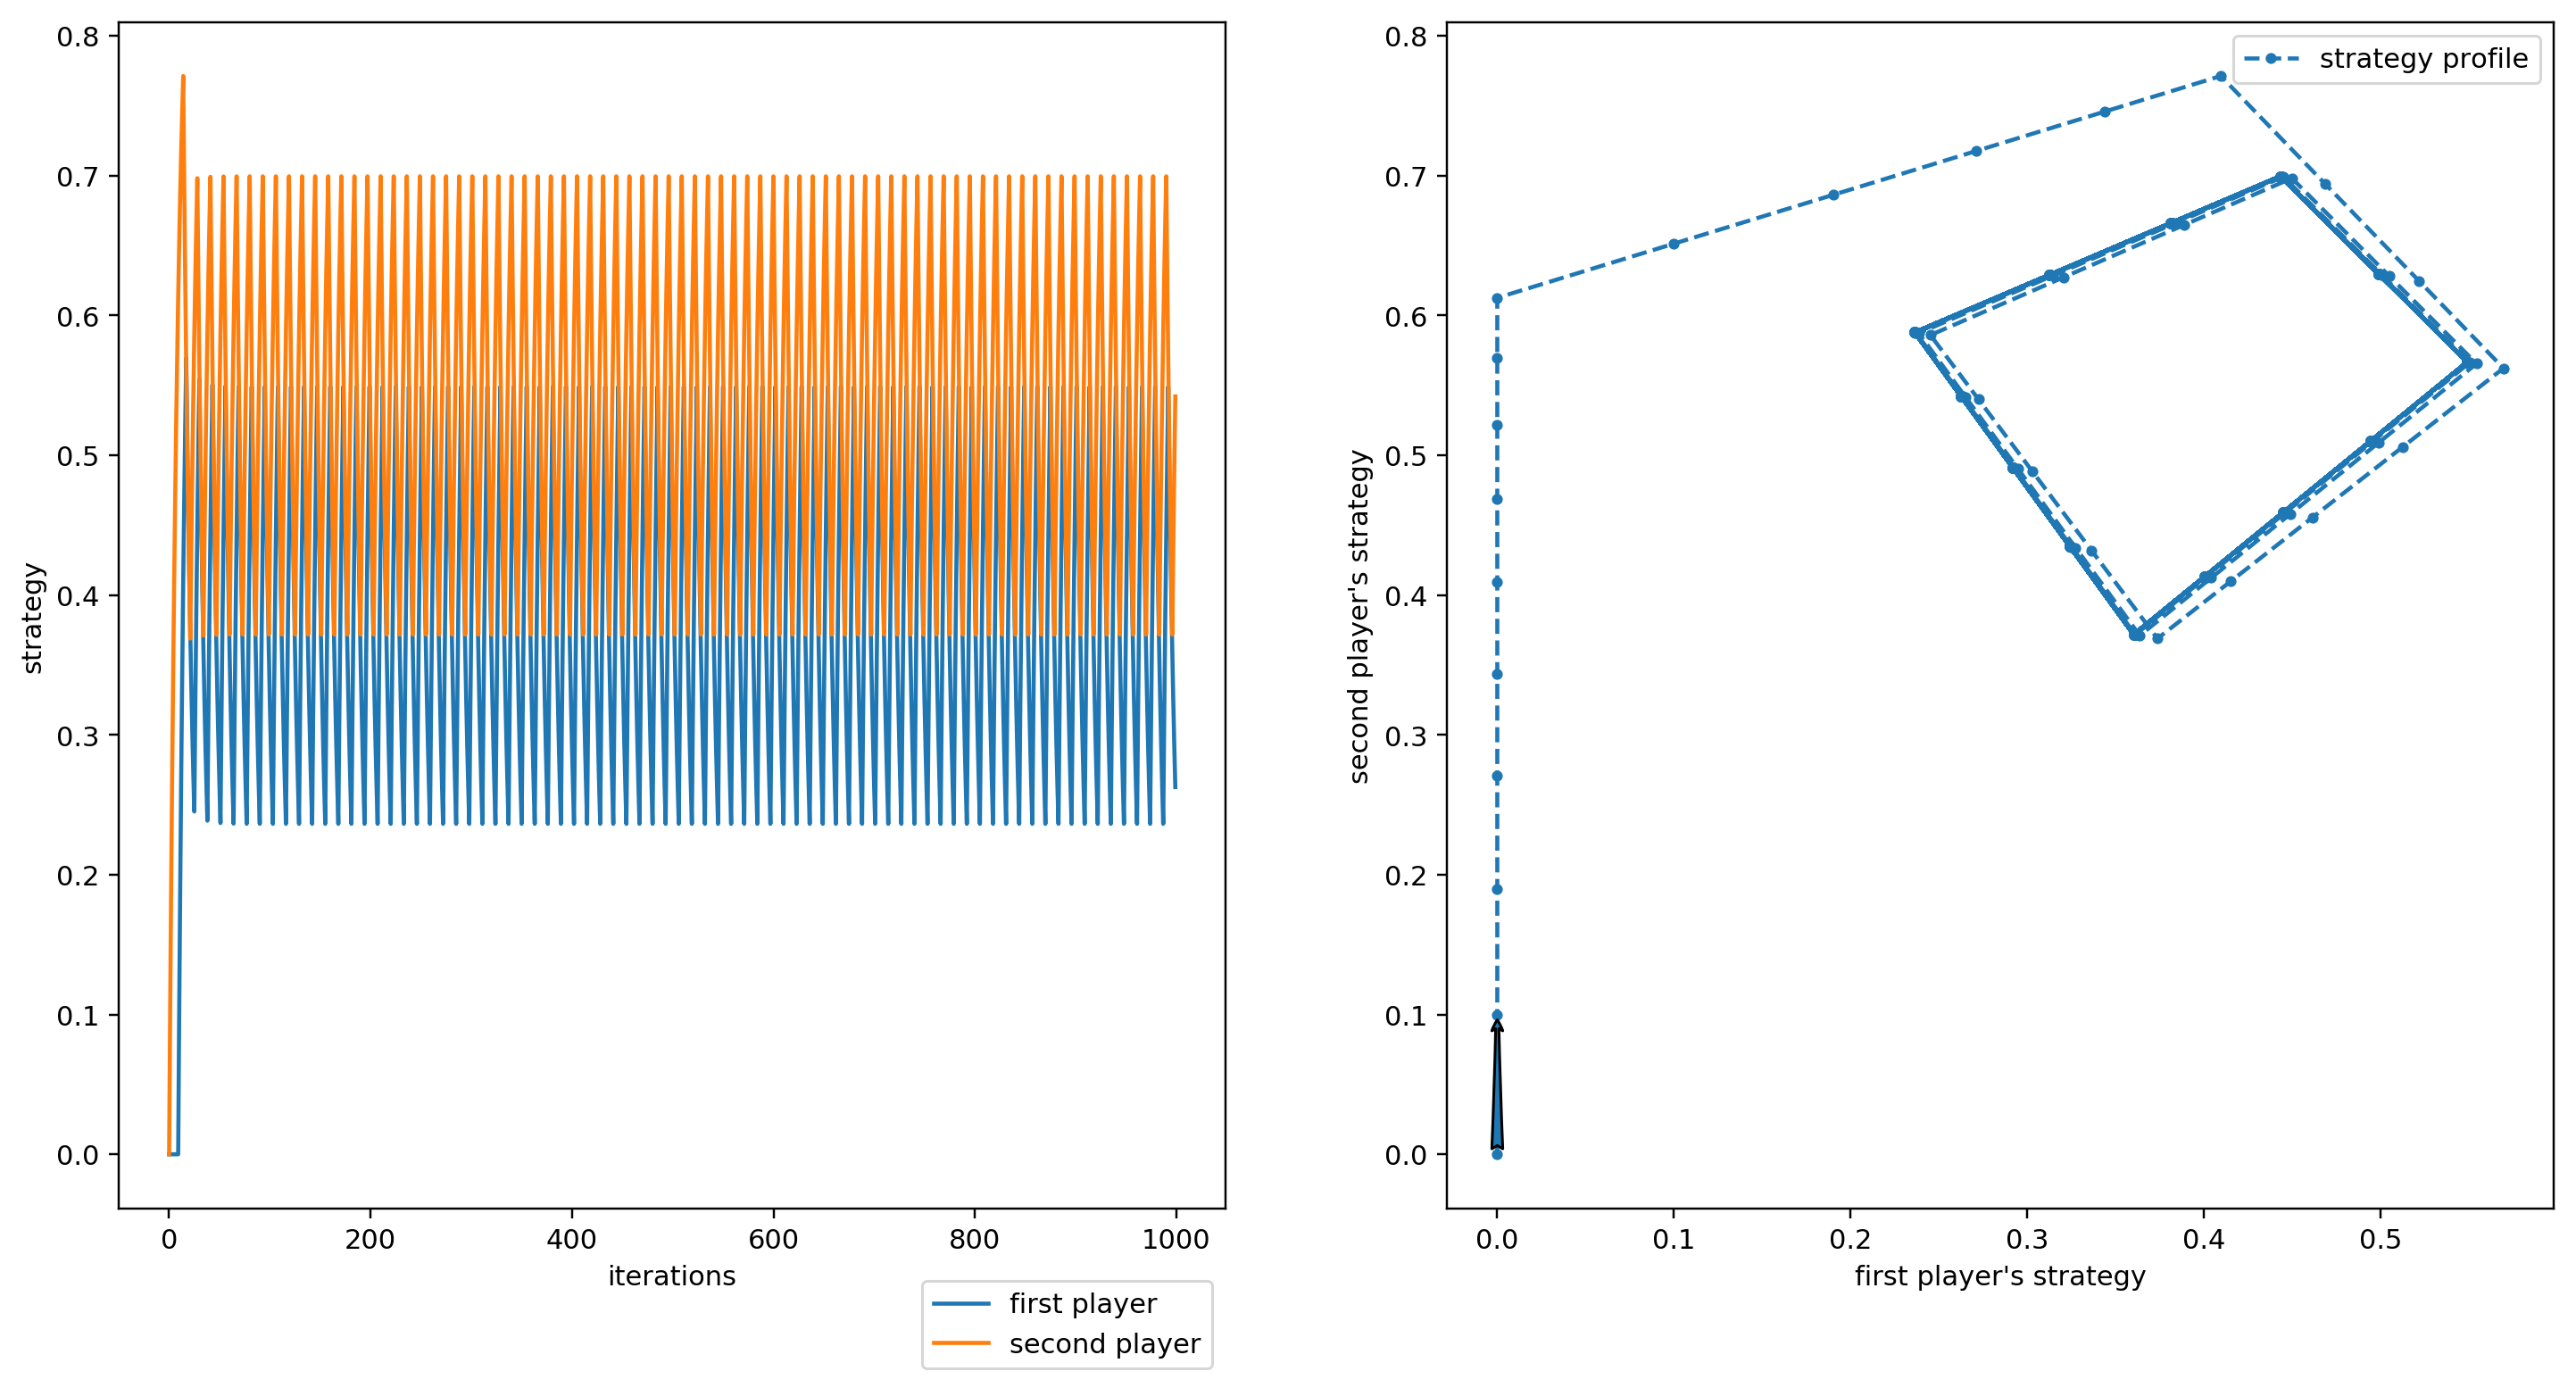

In [15]:
make_plot(strategy)

Again, after 1000 iterations, the damped best response dynamics seems to have stuck in a cycle of four mixed strategy profiles. As the reader can easily verify, increasing the number of iterations of the dynamics does not lead to convergence. 

## Fictitious Play

One reason why best response dynamics fails to converge is that the
players, by playing the best response to only what was played in the
previous time period, forget all that was played before. In fact this
"forgetting the past" feature of best response dynamics ensures that
the convergence, if it happens, is fast. But this also ensures that
the strategies swing wildly when there is no convergence.

One possible remedy is to consider not just what was played the
previous time period, but at all the time periods before time $t$ when
choosing a best response. This leads to a learning dynamics known as
\textit{fictitious play}, introduced by George Brown \cite{brown1951} and
further analyzed by Julia Robinson \cite{robinson1951iterative} in 1951. Here, each player assumes that the other players' strategies are given by the respective empirical distributions of their actions.

To formally define fictitious play, we begin by defining the empirical
distribution at time $t$, which is given by
\begin{align*}
  \gamma_i^t(s) &=  \frac{\text{Number of times a pure strategy $s$ was played by player $i$ before time $t$}}{t}\\
                &= \frac{1}{t} \sum_{\tau=0}^{t-1} \mathbf{I}\{ s_i^\tau = s\} , \quad \text{for all $s \in \mathcal{S}_i$}.
\end{align*}
(Note $\mathbf{I}\{A\}$ is equal
to $1$ if $A$ is true, and zero otherwise.) 

The empirical distribution $\gamma_i^t$ denotes a distribution over
the set of pure strategies, with $\gamma_i^t(s)$ denoting the fraction
of the time until time $t$ that player $i$ played (pure) strategy
$s$. Let
$\gamma_{-i}^t = (\gamma_1^t , \cdots,\gamma_{i-1}^t, \gamma_{i+1}^t ,
\cdots, \gamma_N^t)$ denote the empirical distribution of all players
other than player $i$.


In fictitious play, each player $i$ at each time $t\geq 1$, assumes
that all other players are choosing their strategies according to the
empirical distribution $\gamma_{-i}^t$, and plays a best
response. Formally, for all $t \geq 1$, and for each $i$, we have
\begin{align*}
\sigma_i^t \in BR_i(\gamma_{-i}^{t}).
\end{align*}

The following code computes the players' strategies and the empirical distributions under fictitious play for the 2x2 game considered earlier.

In [16]:
# number of iterations
num_iter = 5000

# 'strategy' stores each players' mixed strategy (probability of action 1 in each case)
strategy = numpy.zeros([num_iter,3])

# 'empirical' stores the empirical distribution of each players' actions
empirical = numpy.zeros([num_iter,3])

payoffs = numpy.zeros([2,2])

for i in range(1,num_iter):
    
    # calculate payoff of player 1 assuming the other player plays according to empirical dist.
    payoffs[0,0] = (1-empirical[i-1,1])*payoff_matrix[0,0] + empirical[i-1,1]*payoff_matrix[0,1]
    payoffs[1,0] = (1-empirical[i-1,1])*payoff_matrix[1,0] + empirical[i-1,1]*payoff_matrix[1,1]

    # calculate payoff of player 2 assuming the other player plays according to empirical dist.
    payoffs[0,1] = (1-empirical[i-1,0])*payoff_matrix[2,0] + empirical[i-1,0]*payoff_matrix[3,0]
    payoffs[1,1] = (1-empirical[i-1,0])*payoff_matrix[2,1] + empirical[i-1,0]*payoff_matrix[3,1]


    # player 1's best response
    if payoffs[0,0] < payoffs[1,0]:
        strategy[i,0] = 1
    elif payoffs[0,0] > payoffs[1,0]:
        strategy[i,0] = 0
    else:
        strategy[i,0] = strategy[i-1,0]


    # player 2's best response
    if  payoffs[0,1] < payoffs[1,1]:
        strategy[i,1] = 1
    elif payoffs[0,1] > payoffs[1,1]:
        strategy[i,1] = 0
    else:
        strategy[i,1] = strategy[i-1,1]


    # update the empirical distribution
    empirical[i,0] = ((i-1)*empirical[i-1,0] + strategy[i,0])/i
    empirical[i,1] = ((i-1)*empirical[i-1,1] + strategy[i,1])/i
        
    # store the (normalized) number of iterations
    strategy[i,2] = i/num_iter
    empirical[i,2] = i/num_iter

We first plot the strategy of the two players.

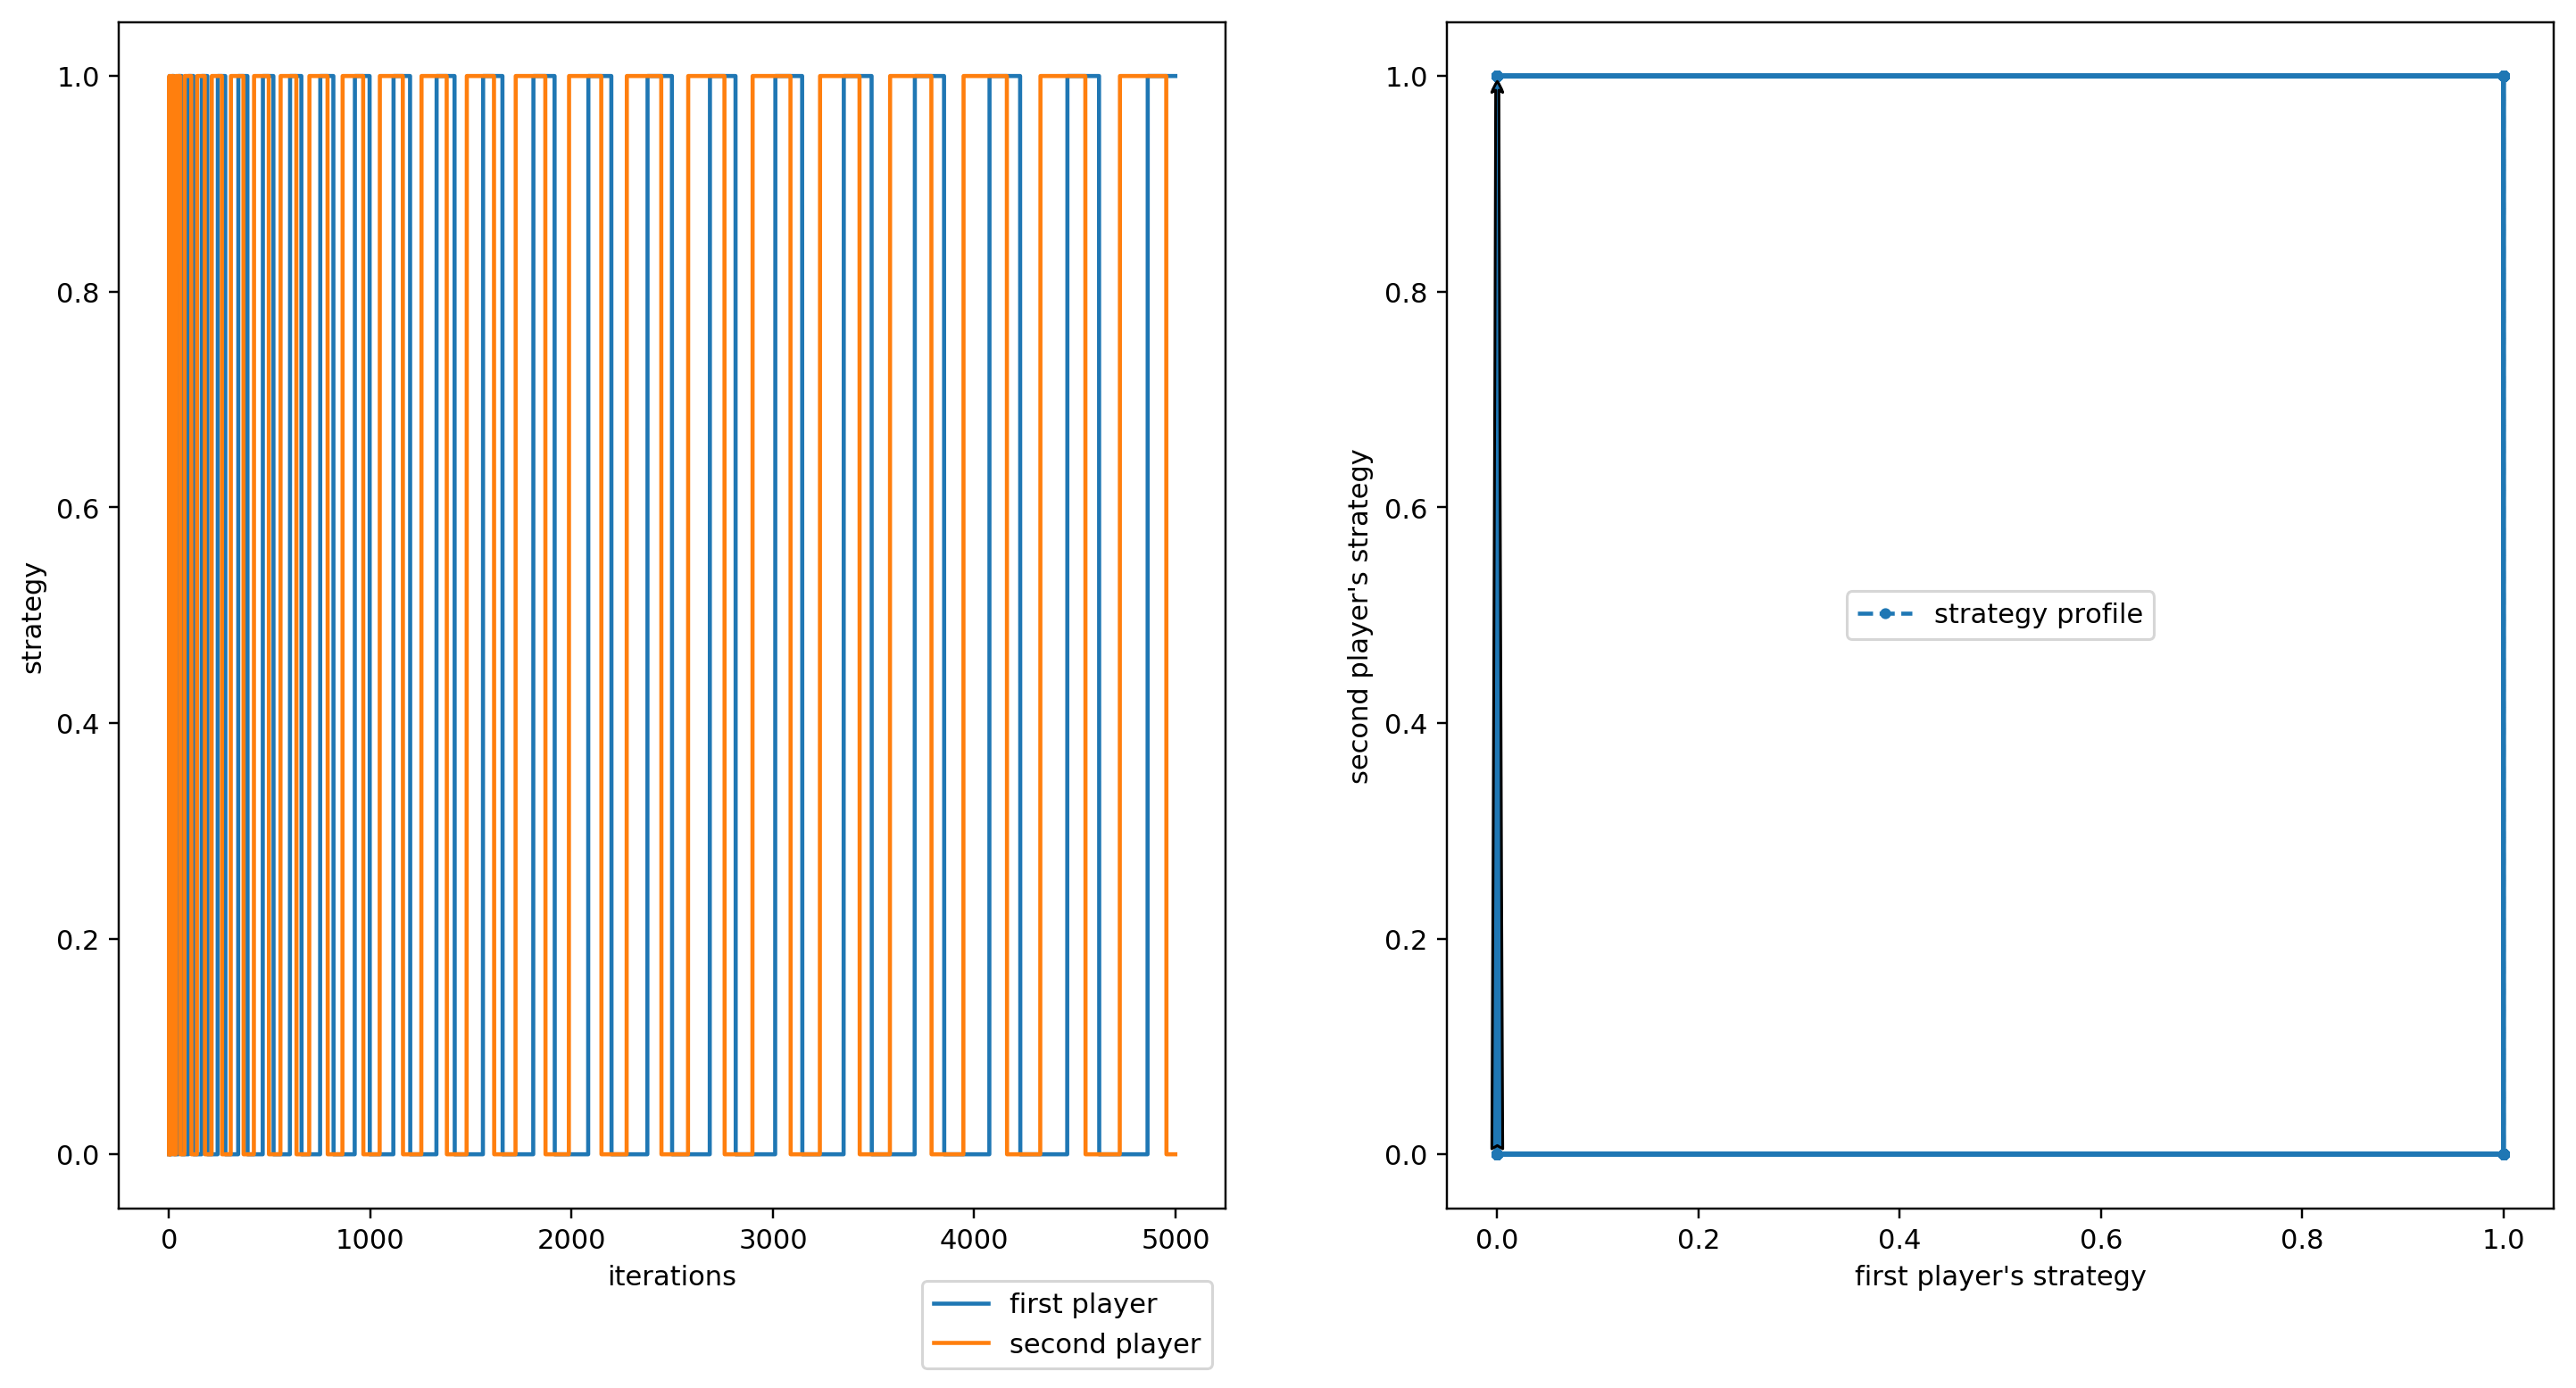

In [17]:
make_plot(strategy)

Despite considering the entire past history of other players' actions which choosing her own, we see that, disappointingly, the strategies of the two players still do not converge. Instead, they keep cycling among the same set of pure strategy profiles.

Given this, let's plot the empirical distribution.

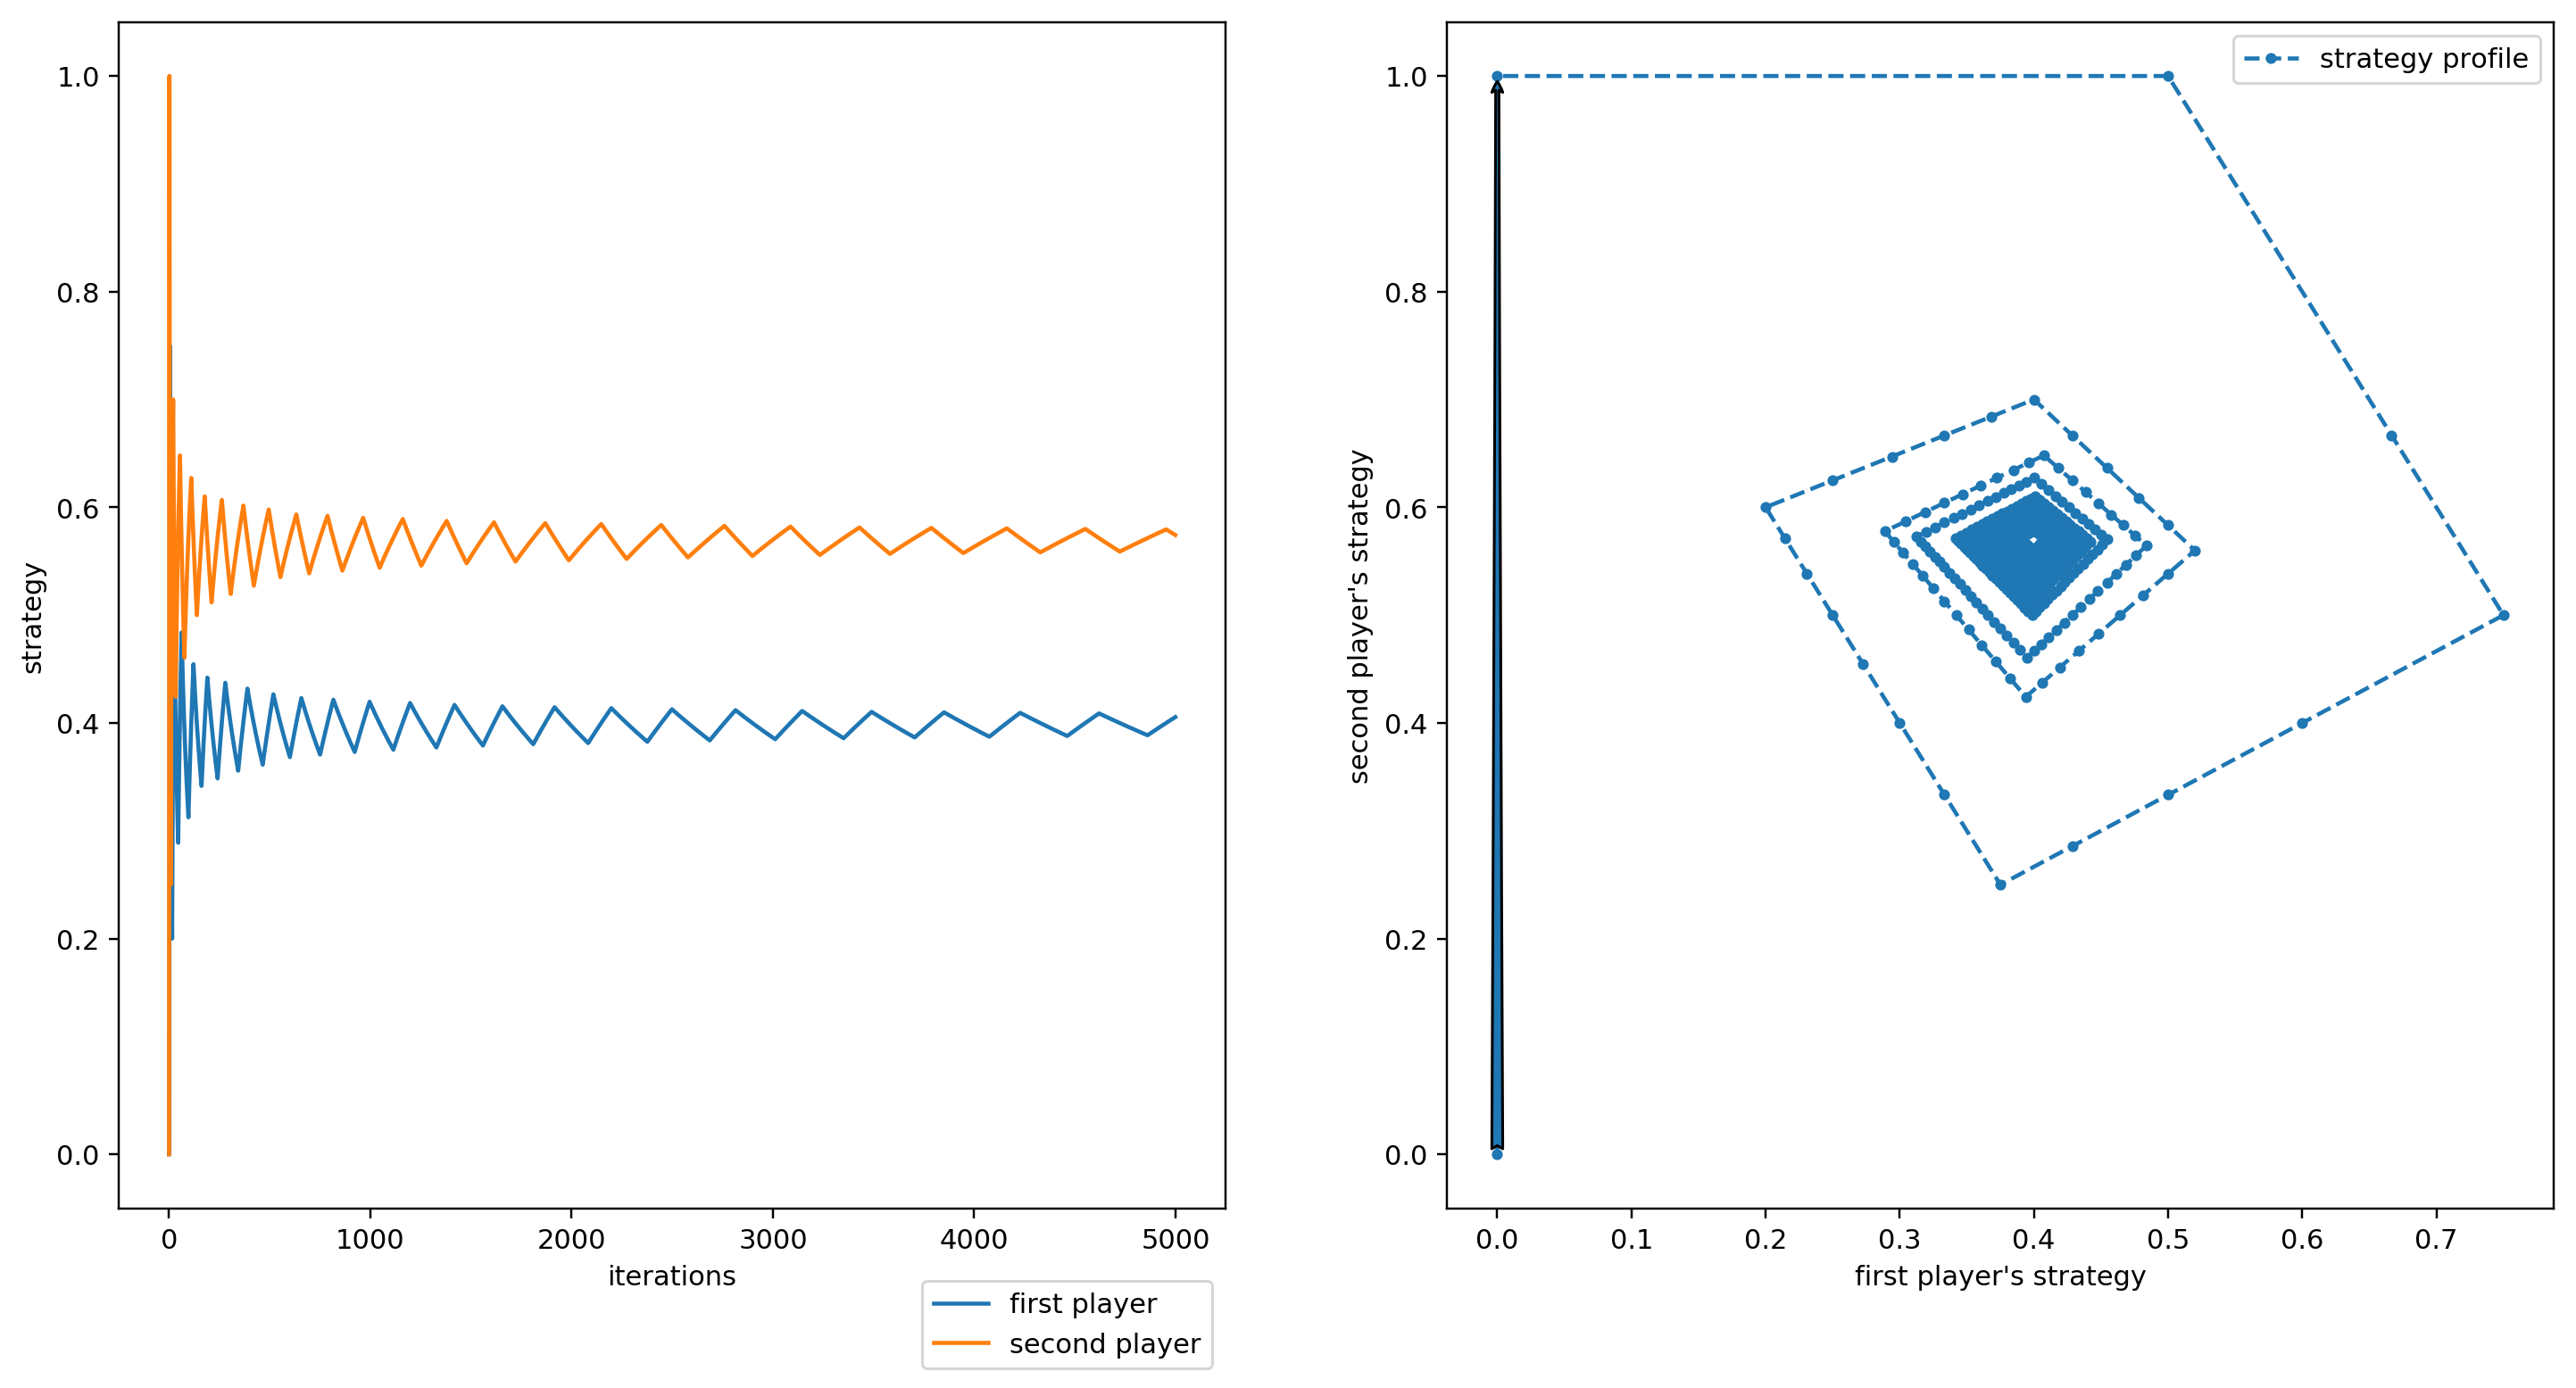

In [18]:
make_plot(empirical)

Interestingly, we see that the empirical distributions indeed converge. (The amplitude of the oscillation becomes smaller with more iterations, as can be easily checked.) It is also easy to verify that the limiting probabilities actually constitute a mixed Nash equilibrium. This mixed Nash equilibrium is (approximately) given by

In [19]:
print("Player 1's strategy: ["+ str(round(empirical[num_iter-1,0],3))
      + "," + str(round(1-empirical[num_iter-1,0],3)) + "]")
print("Player 2's strategy: ["+ str(round(empirical[num_iter-1,1],3))
      + "," + str(round(1-empirical[num_iter-1,1],3)) + "]")

Player 1's strategy: [0.405,0.595]
Player 2's strategy: [0.574,0.426]


Thus, we have an example of a setting where the best response dynamics does not converge, but under fictitious play, the empirical distribution $\gamma^t$ converges. Using similar arguments as in the best response dynamics, one can show that if the empirical distribution under fictitious play converges, it must converge to a (mixed) Nash equilibrium. 


More interestingly, for many classes of games, one can show that under fictitious play, the empirical distribution $\gamma^t$ **must** converge (and hence must converge to a mixed Nash equilibrium). One such class of games is the class of \textit{zero-sum games}, which are two-player games where one
player's gain is another player's loss. (For details, refer \cite{robinson1951iterative}.) Similarly, the empirical distribution under fictitious play always converges for any game (with any number of players) that is _dominance solvable_. (For details, refer \cite{nachbar1990}.)


However, one can also show that there exist games where the fictitious
play does not converge, but cycles. In fact, there is currently no
known algorithm that always converges to a Nash equilibrium for a
general finite game. This is an open problem and an area of active
research.

# References

(<a id="cit-brown1951" href="#call-brown1951">Brown, 1951</a>) George W. Brown, ``_Iterative Solution of Games by Fictitious Play_'',  1951.

(<a id="cit-robinson1951iterative" href="#call-robinson1951iterative">Robinson, 1951</a>) Robinson Julia, ``_An iterative method of solving a game_'', Annals of mathematics, vol. , number , pp. 296--301,  1951.

(<a id="cit-nachbar1990" href="#call-nachbar1990">Nachbar, 1990</a>) Nachbar J. H., ``_``Evolutionary selection'' dynamics in games: Convergence and limit properties_'', International Journal of Game Theory, vol. 19, number 1, pp. 59--89, Mar 1990.

